In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


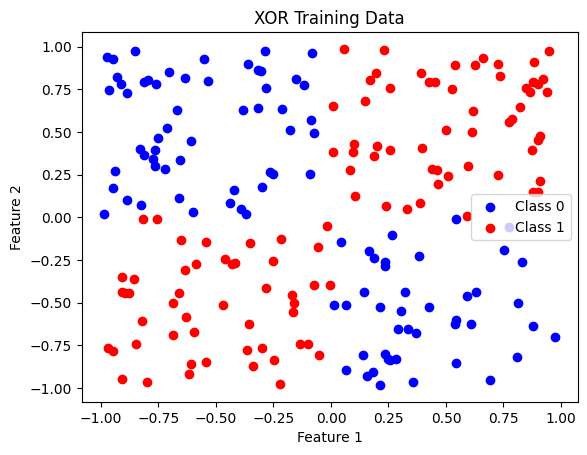

Training data shape: (200, 2) (200,)
Test data shape: (200, 2) (200,)


In [2]:
np.random.seed(42)

# Function to generate XOR dataset
def generate_xor_data(num_samples):
    X = np.random.rand(num_samples, 2) * 2 - 1  # Random points in the range [-1, 1]
    y = (X[:, 0] * X[:, 1] > 0).astype(int)      # XOR logic: 1 if both signs match, 0 otherwise
    return X, y


X, y = generate_xor_data(400)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


# Plot training data
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='red', label='Class 1')
plt.title("XOR Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

print("Training data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)


In [26]:
def transform_features(X, features_to_include):
    transformed_features = []
    for feature in features_to_include:
        if feature == 'x1':
            transformed_features.append(X[:, 0])
        elif feature == 'x2':
            transformed_features.append(X[:, 1])
        elif feature == 'x1^2':
            transformed_features.append(X[:, 0]**2)
        elif feature == 'x2^2':
            transformed_features.append(X[:, 1]**2)
        elif feature == 'x1*x2':
            transformed_features.append(X[:, 0] * X[:, 1])
    return np.column_stack(transformed_features)


# L1 Regularized Function
def l1_loss_with_regularization(model, criterion, outputs, targets, l1_penalty):
    # Standard loss
    base_loss = criterion(outputs, targets)
    # L1 regularization term
    l1_reg = sum(torch.norm(param, 1) for param in model.parameters())
    # Total loss
    return base_loss + l1_penalty * l1_reg

# L2 Regularized Function
def l2_loss_with_regularization(model, criterion, outputs, targets, l2_penalty):
    # Standard loss
    base_loss = criterion(outputs, targets)
    # L2 regularization term
    l2_reg = sum(torch.norm(param, 2)**2 for param in model.parameters())
    # Total loss
    return base_loss + l2_penalty * l2_reg


# MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
        
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    with torch.no_grad():
        zz = model(grid).reshape(xx.shape).numpy()

    plt.contourf(xx, yy, zz, levels=[0, 0.5, 1], colors=['#AAAAFF', '#FFAAAA'], alpha=0.6)

    # plt.contourf(xx, yy, zz, levels=[0, 0.5, 1], cmap='viridis', alpha=0.6)
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()



In [5]:
input_size = 2      
hidden_size = 64    
output_size = 1    
learning_rate = 0.01


model = MLP(input_size, hidden_size, output_size)
criterion = nn.BCELoss()              # Binary Cross-Entropy 
optimizer = optim.Adam(model.parameters(), lr=0.01)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

# Training loop
num_epochs = 750
for epoch in range(num_epochs):

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    test_outputs = model(X_test_tensor)
    test_preds = (test_outputs > 0.5).float()  # Threshold at 0.5 for binary prediction

y_test_np = y_test_tensor.numpy()
test_preds_np = test_preds.numpy()
accuracy = accuracy_score(y_test_np, test_preds_np)
precision = precision_score(y_test_np, test_preds_np)
recall = recall_score(y_test_np, test_preds_np)
f1 = f1_score(y_test_np, test_preds_np)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")



Epoch [10/750], Loss: 0.3380
Epoch [20/750], Loss: 0.1011
Epoch [30/750], Loss: 0.0483
Epoch [40/750], Loss: 0.0330
Epoch [50/750], Loss: 0.0259
Epoch [60/750], Loss: 0.0221
Epoch [70/750], Loss: 0.0196
Epoch [80/750], Loss: 0.0177
Epoch [90/750], Loss: 0.0161
Epoch [100/750], Loss: 0.0148
Epoch [110/750], Loss: 0.0136
Epoch [120/750], Loss: 0.0125
Epoch [130/750], Loss: 0.0116
Epoch [140/750], Loss: 0.0108
Epoch [150/750], Loss: 0.0099
Epoch [160/750], Loss: 0.0091
Epoch [170/750], Loss: 0.0084
Epoch [180/750], Loss: 0.0077
Epoch [190/750], Loss: 0.0071
Epoch [200/750], Loss: 0.0065
Epoch [210/750], Loss: 0.0059
Epoch [220/750], Loss: 0.0054
Epoch [230/750], Loss: 0.0050
Epoch [240/750], Loss: 0.0045
Epoch [250/750], Loss: 0.0042
Epoch [260/750], Loss: 0.0038
Epoch [270/750], Loss: 0.0035
Epoch [280/750], Loss: 0.0032
Epoch [290/750], Loss: 0.0029
Epoch [300/750], Loss: 0.0027
Epoch [310/750], Loss: 0.0025
Epoch [320/750], Loss: 0.0023
Epoch [330/750], Loss: 0.0021
Epoch [340/750], Lo

#

### L1 regularisation

In [6]:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

l1_penalties = [ 0.001,  1, 0.1, 0.01  ]  # Different  penalties to try

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

best_val_loss = float('inf')
best_model = None
best_penalt_l1y = None

for l1_penalty in l1_penalties:
    print(f'penalty : {l1_penalty}')

    model_l1 = MLP(input_size, hidden_size, output_size)
    criterion = nn.BCELoss()  
    optimizer = optim.Adam(model_l1.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        
        outputs = model_l1(X_train_tensor)
        loss = l1_loss_with_regularization(model, criterion, outputs, y_train_tensor, l1_penalty)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
    with torch.no_grad():
        val_outputs = model_l1(X_val_tensor)
        val_loss = l1_loss_with_regularization(model_l1, criterion, val_outputs, y_val_tensor, l1_penalty)
        val_loss_value = val_loss.item()

     
        if val_loss_value < best_val_loss:
            best_val_loss = val_loss_value
            best_model_l1 = model_l1
            best_penalty_l1 = l1_penalty

print(f"Best L1 Penalty: {best_penalty_l1}, Validation Loss: {best_val_loss:.4f}")

# Test the best model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    test_outputs = best_model_l1(X_test_tensor)
    test_preds = (test_outputs > 0.5).float()

# Calculate performance metrics
y_test_np = y_test_tensor.numpy()
test_preds_np = test_preds.numpy()
accuracy = accuracy_score(y_test_np, test_preds_np)
precision = precision_score(y_test_np, test_preds_np)
recall = recall_score(y_test_np, test_preds_np)
f1 = f1_score(y_test_np, test_preds_np)
print(f"Test Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")



penalty : 0.001
Epoch [10/750], Loss: 1.7962
Epoch [20/750], Loss: 1.5409
Epoch [30/750], Loss: 1.4774
Epoch [40/750], Loss: 1.4594
Epoch [50/750], Loss: 1.4512
Epoch [60/750], Loss: 1.4469
Epoch [70/750], Loss: 1.4441
Epoch [80/750], Loss: 1.4419
Epoch [90/750], Loss: 1.4402
Epoch [100/750], Loss: 1.4387
Epoch [110/750], Loss: 1.4374
Epoch [120/750], Loss: 1.4363
Epoch [130/750], Loss: 1.4353
Epoch [140/750], Loss: 1.4343
Epoch [150/750], Loss: 1.4335
Epoch [160/750], Loss: 1.4327
Epoch [170/750], Loss: 1.4320
Epoch [180/750], Loss: 1.4313
Epoch [190/750], Loss: 1.4307
Epoch [200/750], Loss: 1.4302
Epoch [210/750], Loss: 1.4297
Epoch [220/750], Loss: 1.4292
Epoch [230/750], Loss: 1.4288
Epoch [240/750], Loss: 1.4284
Epoch [250/750], Loss: 1.4281
Epoch [260/750], Loss: 1.4278
Epoch [270/750], Loss: 1.4275
Epoch [280/750], Loss: 1.4273
Epoch [290/750], Loss: 1.4270
Epoch [300/750], Loss: 1.4268
Epoch [310/750], Loss: 1.4266
Epoch [320/750], Loss: 1.4264
Epoch [330/750], Loss: 1.4263
Epo

#

### L2 regularisation

In [7]:
best_val_loss = float('inf')
best_model_l2 = None
best_penalty_l2 = None

for l2_penalty in l1_penalties:

    model_l2 = MLP(input_size, hidden_size, output_size)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
    optimizer = optim.Adam(model_l2.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        outputs = model_l2(X_train_tensor)
        loss = l2_loss_with_regularization(model_l2, criterion, outputs, y_train_tensor, l2_penalty)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        val_outputs = model_l2(X_val_tensor)
        val_loss = l2_loss_with_regularization(model_l2, criterion, val_outputs, y_val_tensor, l2_penalty)
        val_loss_value = val_loss.item()

        # Track the best model 
        if val_loss_value < best_val_loss:
            best_val_loss = val_loss_value
            best_model_l2 = model_l2
            best_penalty_l2 = l2_penalty

print(f"Best L2 Penalty: {best_penalty_l2}, Validation Loss: {best_val_loss:.4f}")

# Test the best model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    test_outputs = best_model_l2(X_test_tensor)
    test_preds = (test_outputs > 0.5).float()

y_test_np = y_test_tensor.numpy()
test_preds_np = test_preds.numpy()
accuracy = accuracy_score(y_test_np, test_preds_np)
precision = precision_score(y_test_np, test_preds_np)
recall = recall_score(y_test_np, test_preds_np)
f1 = f1_score(y_test_np, test_preds_np)
print(f"Test Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Best L2 Penalty: 0.001, Validation Loss: 0.1098
Test Metrics - Accuracy: 0.9900, Precision: 0.9818, Recall: 1.0000, F1 Score: 0.9908


---
#
#
### Logistic regression


In [34]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Choose features to include 
# features_to_include = ['x1', 'x2', 'x1^2', 'x2^2', 'x1*x2']
features_to_include = ['x1', 'x2']
# Transform specified features
X_train_transformed1 = transform_features(X_train, features_to_include)
X_test_transformed1 = transform_features(X_test, features_to_include)
features_to_include = ['x1', 'x2', 'x1^2', 'x2^2']
X_train_transformed2 = transform_features(X_train, features_to_include)
X_test_transformed2= transform_features(X_test, features_to_include)
features_to_include = ['x1', 'x2', 'x1^2', 'x2^2', 'x1*x2']
X_train_transformed3 = transform_features(X_train, features_to_include)
X_test_transformed3 = transform_features(X_test, features_to_include)

log_reg1 = LogisticRegression()
log_reg2 = LogisticRegression()
log_reg3 = LogisticRegression()
log_reg1.fit(X_train_transformed1, y_train)
log_reg2.fit(X_train_transformed2, y_train)
log_reg3.fit(X_train_transformed3, y_train)

X_test_transformed = [X_test_transformed1, X_test_transformed2, X_test_transformed3]
feat = [['x1', 'x2'], ['x1', 'x2', 'x1^2', 'x2^2'], ['x1', 'x2', 'x1^2', 'x2^2', 'x1*x2']]
p = 0
for mod in [log_reg1, log_reg2, log_reg3] : 
        y_pred = mod.predict(X_test_transformed[p])
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"Logistic regression with features : {feat[p]} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        p+=1

# Plot decision boundary
def plot_decision_boundary_log(model, X, y, features_to_include, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_transformed = transform_features(grid, features_to_include)
    with torch.no_grad():
        zz = model.predict(grid_transformed).reshape(xx.shape)

    plt.contourf(xx, yy, zz, levels=[0, 0.5, 1], colors=[ '#AAAAFF', '#FFAAAA'], alpha=0.6)
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()

# plot_decision_boundary(log_reg, X_test, y_test, features_to_include, title="Logistic Regression Decision Boundary with Custom Features")


Logistic regression with features : ['x1', 'x2'] - Accuracy: 0.5750, Precision: 0.5810, Recall: 0.5980, F1 Score: 0.5894
Logistic regression with features : ['x1', 'x2', 'x1^2', 'x2^2'] - Accuracy: 0.5400, Precision: 0.5532, Recall: 0.5098, F1 Score: 0.5306
Logistic regression with features : ['x1', 'x2', 'x1^2', 'x2^2', 'x1*x2'] - Accuracy: 0.9500, Precision: 0.9259, Recall: 0.9804, F1 Score: 0.9524


#
#
#
# Visualtizations of decision boundaries

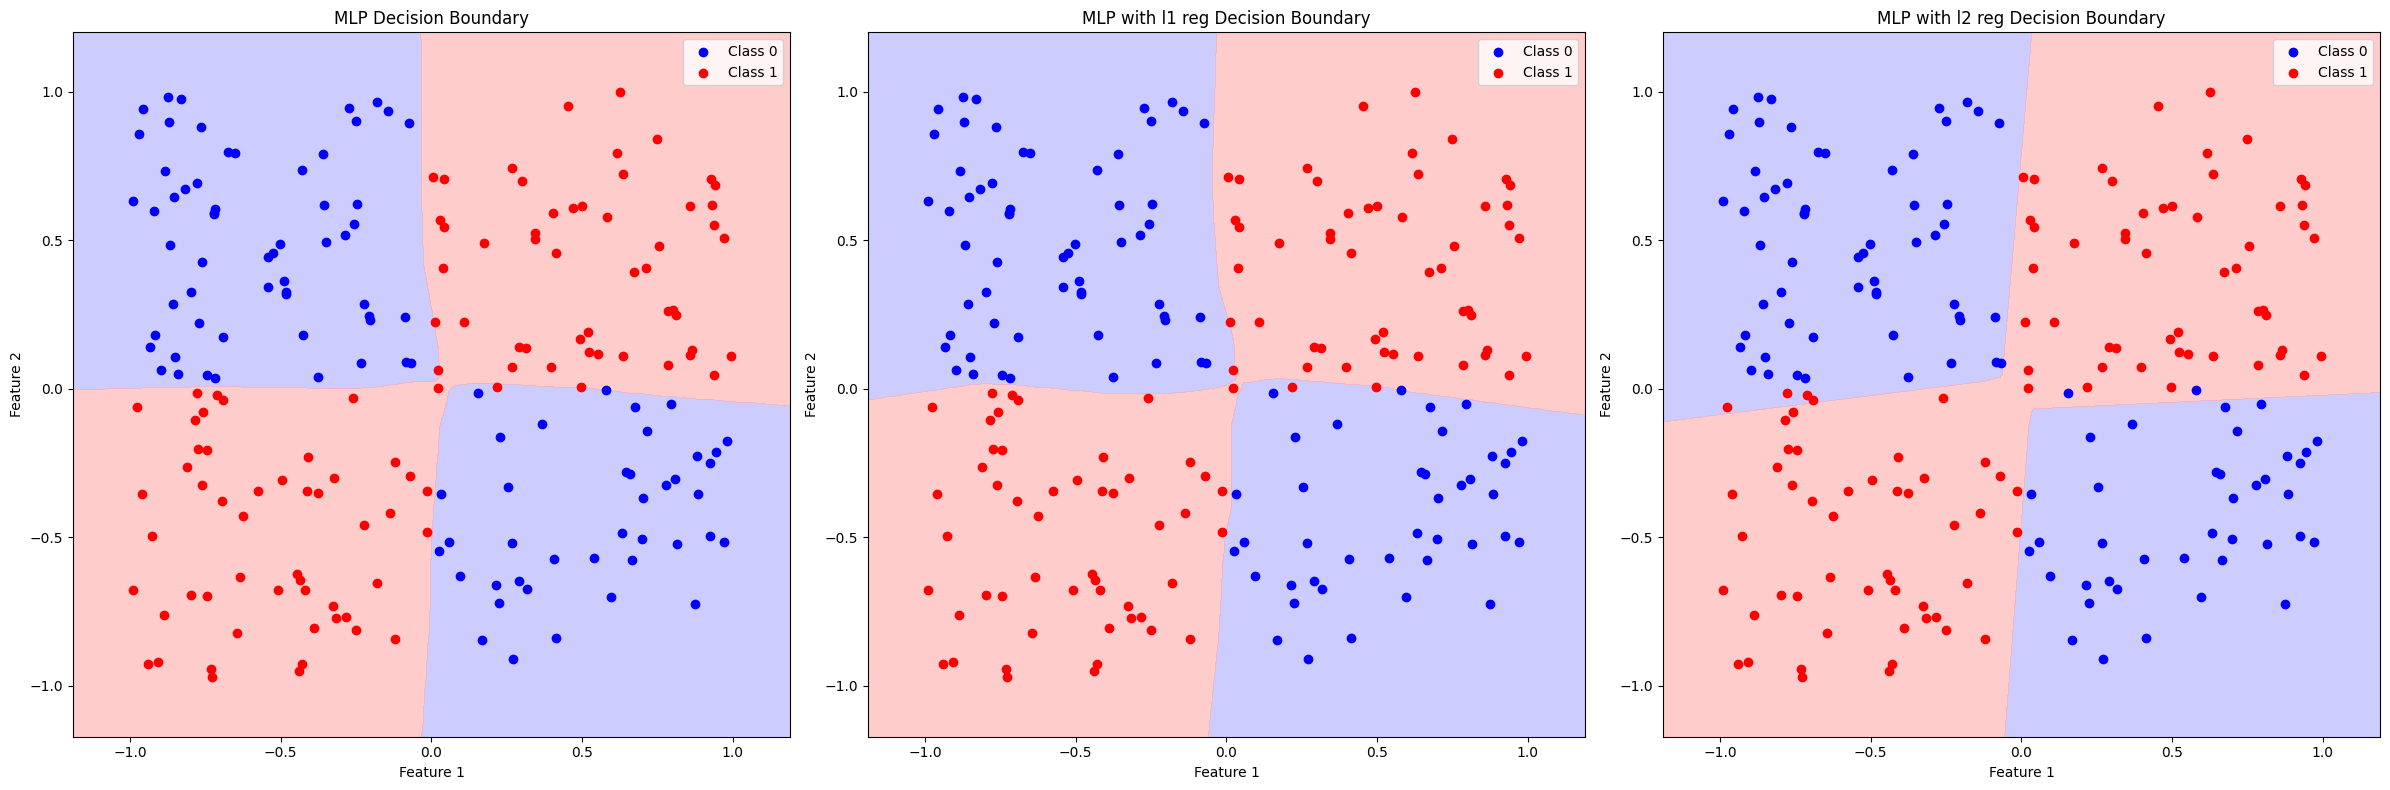

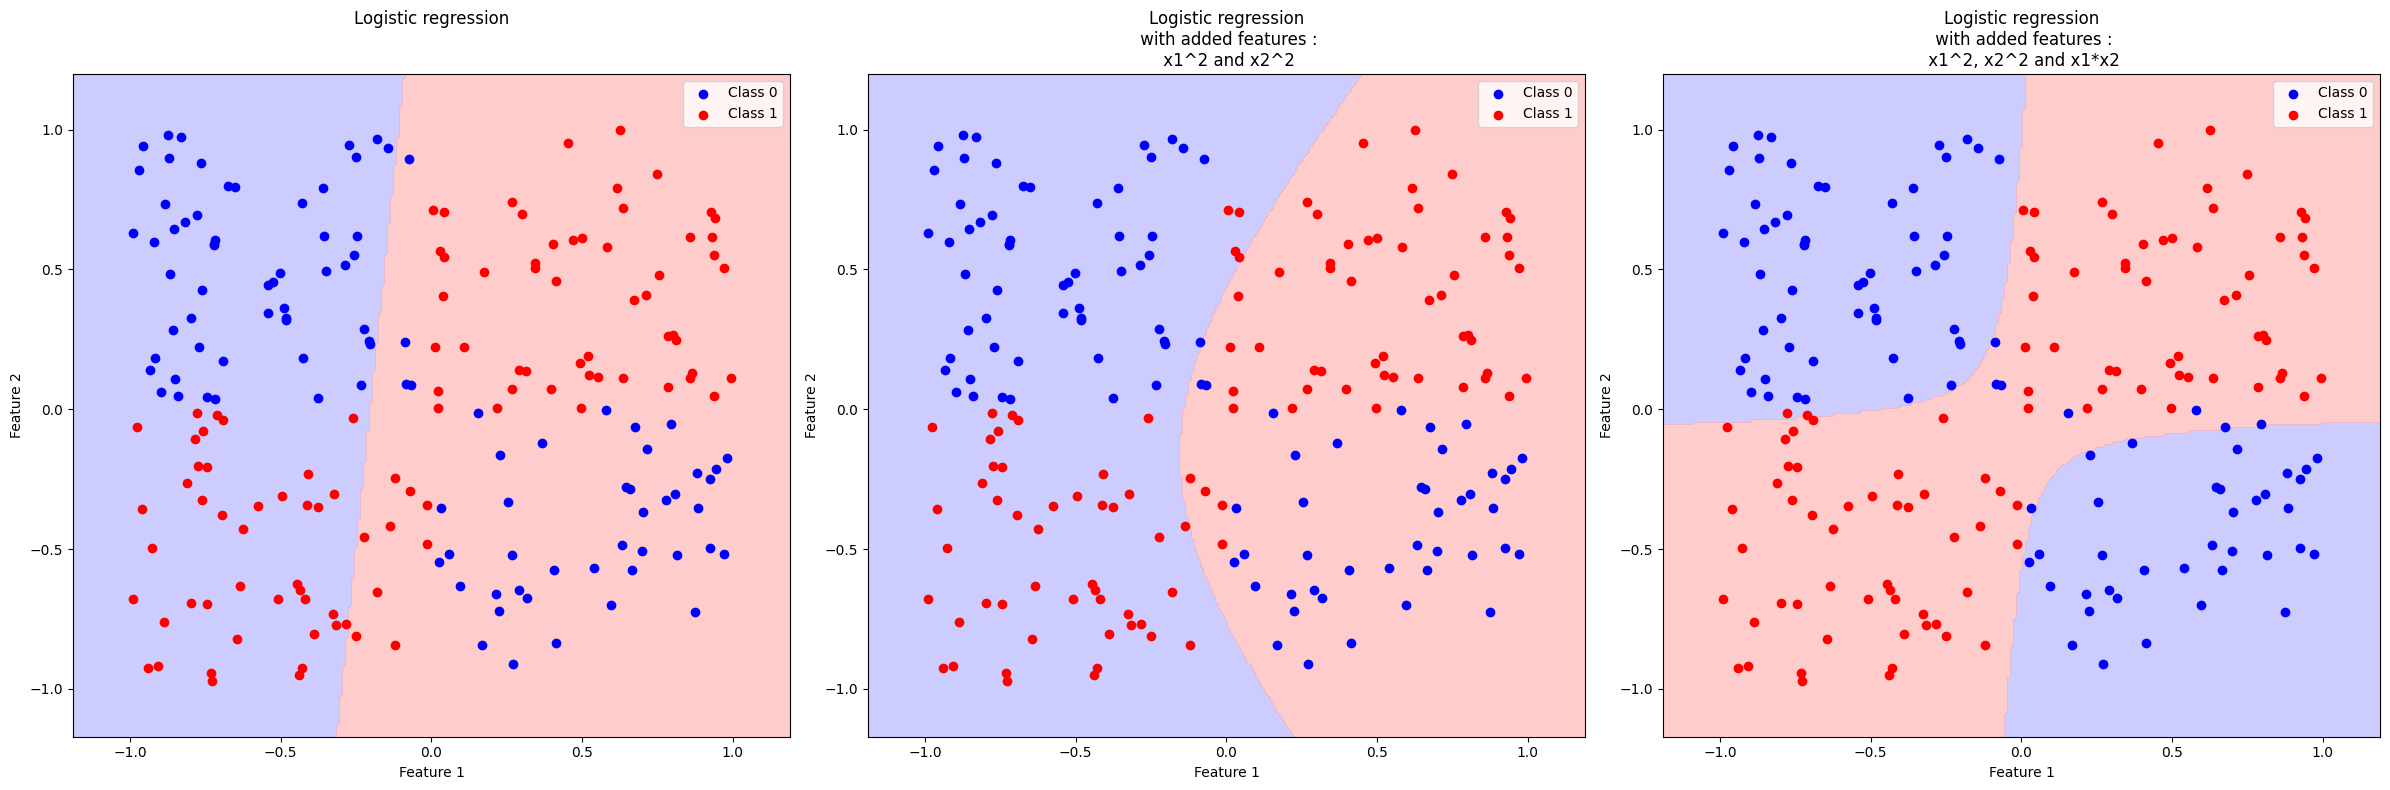

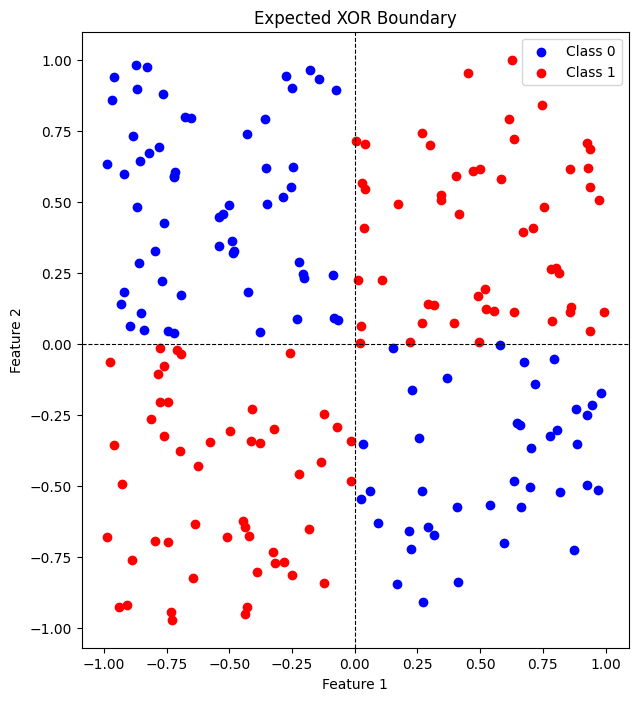

In [37]:
plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
plot_decision_boundary(model, X_test, y_test, title="MLP Decision Boundary")
plt.subplot(1, 3, 2)
plot_decision_boundary(model_l1, X_test, y_test, title="MLP with l1 reg Decision Boundary")
plt.subplot(1, 3, 3)
plot_decision_boundary(model_l2, X_test, y_test, title="MLP with l2 reg Decision Boundary")
plt.tight_layout()
plt.show()

plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
plot_decision_boundary_log(log_reg1, X_test, y_test, feat[0],  title="Logistic regression\n\n")
plt.subplot(1, 3, 2)
plot_decision_boundary_log(log_reg2, X_test, y_test,feat[1],title="Logistic regression\n with added features :\n x1^2 and x2^2")
plt.subplot(1, 3, 3)
plot_decision_boundary_log(log_reg3, X_test, y_test,feat[2], title="Logistic regression\n with added features :\n x1^2, x2^2 and x1*x2")
plt.tight_layout()
plt.show()




plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 2)
plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color='red', label='Class 1')
plt.axhline(0, color="black", linestyle="--", lw=0.8)
plt.axvline(0, color="black", linestyle="--", lw=0.8)
plt.title("Expected XOR Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()